In [53]:
import os 

import azureml.core
from azureml.core import Workspace, Dataset, Datastore, Experiment, Environment, ScriptRunConfig

from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

from azureml.core.runconfig import PyTorchConfiguration, DockerConfiguration
from azureml.core.conda_dependencies import CondaDependencies

from azureml.data import OutputFileDatasetConfig
from azureml.telemetry import set_diagnostics_collection
from azureml.widgets import RunDetails

set_diagnostics_collection(send_diagnostics=True)

print("SDK version:", azureml.core.VERSION)

Turning diagnostics collection on. 
SDK version: 1.38.0


In [54]:
azureml._restclient.snapshots_client.SNAPSHOT_MAX_SIZE_BYTES = 1000000000

In [55]:
project_folder = '../dino'


In [56]:
ws = Workspace.from_config()
datastore = ws.get_default_datastore()
image_net_dataset = Dataset.get_by_name(ws, 'imagenet_2015_premium_west_full')

In [57]:
# choose a name for your cluster
cluster_name = 'A100-2'
try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Cannot Find the compute cluster')

# use get_status() to get a detailed status for the current AmlCompute. 
print(compute_target.get_status().serialize())

Found existing compute target.
{'currentNodeCount': 2, 'targetNodeCount': 1, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 1, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 1, 'preemptedNodeCount': 0}, 'allocationState': 'Resizing', 'allocationStateTransitionTime': '2022-03-07T11:16:51.462000+00:00', 'errors': None, 'creationTime': '2022-03-06T10:48:17.444629+00:00', 'modifiedTime': '2022-03-07T08:23:54.464919+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 1, 'maxNodeCount': 2, 'nodeIdleTimeBeforeScaleDown': 'PT30S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_ND96AMSR_A100_V4'}


In [58]:
#pytorch_env = Environment.from_conda_specification(name='AzureML-PyTorch-1.6-GPU',file_path='distributed-pytorch-with-distributeddataparallel.yml')
curated_env_name = 'AzureML-pytorch-1.10-ubuntu18.04-py38-cuda11-gpu'
pytorch_env = Environment.get(workspace=ws, name=curated_env_name)
pytorch_env.environment_variables = {"AZUREML_DOWNLOAD_CONCURRENCY":384} 

dino_env = pytorch_env.clone("dino_env")

conda = CondaDependencies()

# # add pip packages
conda.add_pip_package('timm')
# # create environment
dino_env.python.conda_dependencies = conda
docker_config = DockerConfiguration(use_docker=True, arguments = ['--ipc=host'], shm_size='1024g')




In [59]:
patch_size = 16
batch_size_per_gpu = 64
node_count = 1
process_count = 8
communication_backend = 'NCCL'

In [60]:
#datastore = ws.get_default_datastore()
#out_dataset = Dataset.get_by_name(ws,name='Output_node1_ViTs_gpus8_bacthsize64')


# Inference - Linear

In [61]:
from azureml.core import Experiment
experiment_name = 'exp_Inference_ViTS16'
Inference_experiment = Experiment(ws, name=experiment_name)
# create distributed config
distr_Inference_config = PyTorchConfiguration(node_count=node_count)
#launch_cmd = ["python -m torch.distributed.launch --nproc_per_node=8 eval_linear.py --pretrained_weights",'./checkpoints' , "--checkpoint_key teacher --data_path", image_net_dataset.as_download(),"--patch_size 16 --batch_size_per_gpu 64"]
launch_cmd = ["torchrun --nproc_per_node=7 eval_linear.py --pretrained_weights",'./checkpoints' , "--checkpoint_key teacher --data_path", image_net_dataset.as_download(),"--patch_size 16 --batch_size_per_gpu 64"]

src_config_linear = ScriptRunConfig(
  source_directory=project_folder,
  command=launch_cmd,
  compute_target=compute_target,
  environment=dino_env,
  distributed_job_config=distr_Inference_config
)
runInferenceLinear = Inference_experiment.submit(src_config_linear)

Submitting /mnt/batch/tasks/shared/LS_root/mounts/clusters/ds3-4cores-setu/code/Users/aghasemi/dino directory for run. The size of the directory >= 25 MB, so it can take a few minutes.


In [62]:
runInferenceLinear.tag("author","AFS")
runInferenceLinear.tag("storage" , "premium")
runInferenceLinear.tag("envoirnment" ,'dino_env' )
runInferenceLinear.tag("dataset", "download")
runInferenceLinear.tag("batch_size_per_gpu" , str(batch_size_per_gpu))
runInferenceLinear.tag("patch_size" , str(patch_size))
runInferenceLinear.tag("epochs" , "100")
runInferenceLinear.tag("ENV" , str(curated_env_name))
runInferenceLinear.tag("gpus" , str(process_count))
runInferenceLinear.tag("nodes" , str(node_count))
runInferenceLinear.tag("comment" , "removed evaluate+ data parallel for model added in utils")


In [63]:

RunDetails(runInferenceLinear).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

# Visualise attention

In [64]:
%run visualize_attention --pretrained_weights 'checkpoint.pth' --checkpoint_key 'teacher' --image_path 'img.png' --patch_size 16

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
./attn-head0.png saved.
./attn-head1.png saved.
./attn-head2.png saved.
./attn-head3.png saved.
./attn-head4.png saved.
./attn-head5.png saved.


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


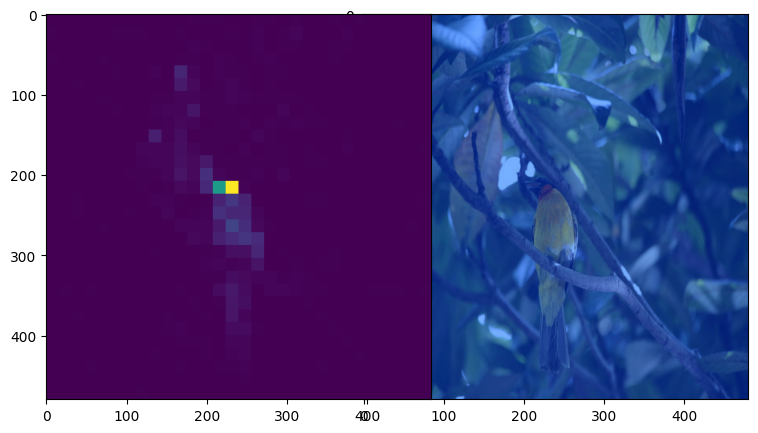

In [65]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 1, 1)
img = plt.imread('img.png')
plt.imshow(img)
fig.add_subplot(1, 2, 1)
attn = plt.imread('attn-head0.png')
plt.imshow(attn)
plt.show()